In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision.io import read_image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import DataLoader

![Depth Inverse Loss](./loss/DepthInverseLoss.png)


In [2]:
from data.loaders.DataLoader import RedWebDataset , Rescale , RandomCrop
normal_dataset = RedWebDataset(root_dir="data/ReDWeb_V1",transform=transforms.Compose([
    Rescale((256,256)),
]))
batcher = DataLoader(normal_dataset,batch_size=1,shuffle=True)

In [3]:
batched = iter(batcher)
sample0 = next(batched)
print(sample0["mono"].shape)
print(sample0["heat"].shape)

sample1 = next(batched)
print(sample1["mono"].shape)
print(sample1["heat"].shape)


torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


/Users/adi/opt/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


/var/folders/f0/_f_gy0t91jqchv14f0hcl_gh0000gn/T/ipykernel_12990/4250501436.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699448803473/work/aten/src/ATen/native/TensorShape.cpp:3618.)
  ax["A"].imshow(sample0["mono"].squeeze(0).T)


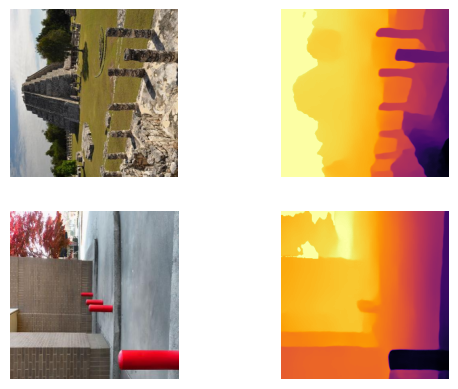

In [4]:
# lets see these images
import matplotlib.pyplot as plt
fig , ax = plt.subplot_mosaic("AB;CD")
ax["A"].imshow(sample0["mono"].squeeze(0).T)
ax["C"].imshow(sample1["mono"].squeeze(0).T)

ax["B"].imshow(sample0["heat"].squeeze(0).T , cmap="inferno")
ax["D"].imshow(sample1["heat"].squeeze(0).T, cmap="inferno")

for k in ax.keys():
    ax[k].grid("off")
    ax[k].axis("off")

In [5]:
# Based on
# https://github.com/tensorflow/models/blob/master/research/struct2depth/model.py#L625-L641


class InverseDepthSmoothnessLoss(nn.Module):
    r"""Criterion that computes image-aware inverse depth smoothness loss.

    .. math::

        \text{loss} = \left | \partial_x d_{ij} \right | e^{-\left \|
        \partial_x I_{ij} \right \|} + \left |
        \partial_y d_{ij} \right | e^{-\left \| \partial_y I_{ij} \right \|}


    Shape:
        - Inverse Depth: :math:`(N, 1, H, W)`
        - Image: :math:`(N, 3, H, W)`
        - Output: scalar

    Examples::

        >>> idepth = torch.rand(1, 1, 4, 5)
        >>> image = torch.rand(1, 3, 4, 5)
        >>> smooth = tgm.losses.DepthSmoothnessLoss()
        >>> loss = smooth(idepth, image)
    """

    def __init__(self) -> None:
        super(InverseDepthSmoothnessLoss, self).__init__()

    @staticmethod
    def gradient_x(img: torch.Tensor) -> torch.Tensor:
        assert len(img.shape) == 4, img.shape
        return img[:, :, :, :-1] - img[:, :, :, 1:]

    @staticmethod
    def gradient_y(img: torch.Tensor) -> torch.Tensor:
        assert len(img.shape) == 4, img.shape
        return img[:, :, :-1, :] - img[:, :, 1:, :]

    def forward(
            self,
            idepth: torch.Tensor,
            image: torch.Tensor) -> torch.Tensor:
        if not torch.is_tensor(idepth):
            raise TypeError("Input idepth type is not a torch.Tensor. Got {}"
                            .format(type(idepth)))
        if not torch.is_tensor(image):
            raise TypeError("Input image type is not a torch.Tensor. Got {}"
                            .format(type(image)))
        if not len(idepth.shape) == 4:
            raise ValueError("Invalid idepth shape, we expect BxCxHxW. Got: {}"
                             .format(idepth.shape))
        if not len(image.shape) == 4:
            raise ValueError("Invalid image shape, we expect BxCxHxW. Got: {}"
                             .format(image.shape))
        if not idepth.shape[-2:] == image.shape[-2:]:
            raise ValueError("idepth and image shapes must be the same. Got: {}"
                             .format(idepth.shape, image.shape))
        if not idepth.device == image.device:
            raise ValueError(
                "idepth and image must be in the same device. Got: {}" .format(
                    idepth.device, image.device))
        if not idepth.dtype == image.dtype:
            raise ValueError(
                "idepth and image must be in the same dtype. Got: {}" .format(
                    idepth.dtype, image.dtype))
        # compute the gradients
        idepth_dx: torch.Tensor = self.gradient_x(idepth)
        idepth_dy: torch.Tensor = self.gradient_y(idepth)
        image_dx: torch.Tensor = self.gradient_x(image)
        image_dy: torch.Tensor = self.gradient_y(image)

        # compute image weights
        weights_x: torch.Tensor = torch.exp(
            -torch.mean(torch.abs(image_dx), dim=1, keepdim=True))
        weights_y: torch.Tensor = torch.exp(
            -torch.mean(torch.abs(image_dy), dim=1, keepdim=True))

        # apply image weights to depth
        smoothness_x: torch.Tensor = torch.abs(idepth_dx * weights_x)
        smoothness_y: torch.Tensor = torch.abs(idepth_dy * weights_y)
        return torch.mean(smoothness_x) + torch.mean(smoothness_y)


In [6]:
sample0["mono"] =  sample0["mono"].to(torch.float)
sample0["heat"] =  sample0["heat"].to(torch.float)

sample1["mono"] = sample1["mono"].to(torch.float)
sample1["heat"] = sample1["heat"].to(torch.float)


In [7]:
inv_loss = InverseDepthSmoothnessLoss()
inv_loss(sample0["heat"],sample0["mono"])

tensor(0.0443)

In [8]:
inv_loss = InverseDepthSmoothnessLoss()
inv_loss(sample0["heat"],sample1["mono"])

tensor(0.4271)

[[0.05815892 0.43454737 0.42718754 0.51708097]
 [0.43454737 3.24681772 3.19182712 3.86348598]
 [0.42718754 3.19182712 3.13776788 3.79805101]
 [0.51708097 3.86348598 3.79805101 4.59727808]]


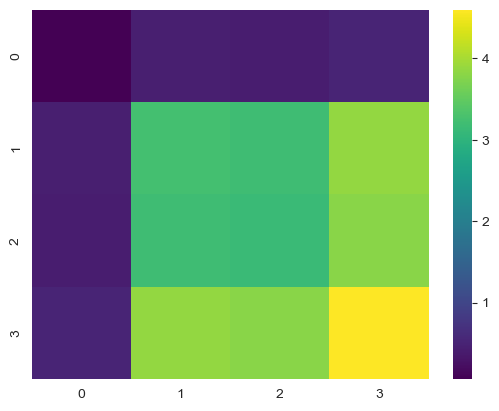

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

e = np.random.randn(4,1)
print(e @ e.T)
sns.heatmap(e @ e.T,cmap="viridis")

plt.show()

